In [1]:
import numpy as np
import matplotlib.pyplot as plt
import mkl

np.random.seed(1234)
mkl.set_num_threads(4)

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams["figure.figsize"] = [16, 9]

## Funkcje pomocnicze

In [2]:
# Add a column of ones at the end of a matrix
def append_ones(matrix, axis=1):
    # matrix.shape[0] -> number of rows
    # axis=1 -> horizontally
    ones = np.ones((matrix.shape[0], 1), dtype=matrix.dtype)
    return np.concatenate((matrix, ones), axis=axis)

In [3]:
%%timeit #the code will be run multiple times

a = np.zeros((100))
b = np.zeros((100))

c = np.empty((100))

for i in range(100):
    c[i] = a[i]+b[i]

46.8 µs ± 3.1 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [4]:
%%timeit

a = np.zeros((100))
b = np.zeros((100))

c = np.empty((100))
c = a+b

5.17 µs ± 246 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


## Propagacja sygnału, funkcja aktywacji i "kafelki"

In [5]:
# Propagacja sygnały przez warstwę w pelni połączoną
def feed_forward(W, dataset, activation_fun):
    #A@B lub np.dot lub np.matmul -> to jest mnozenie macierzy
    # biases
    return activation_fun(dataset @ W)

In [6]:
# Sigmoidalna funkcja aktywacji
def sigmoid(matrix):
    return 1.0 / (1.0 + np.exp(-matrix))

In [7]:
def tiles(examples):
    rows_count = examples.shape[0]
    cols_count = examples.shape[1]
    tile_height = examples.shape[2]
    tile_width = examples.shape[3]
    
    space_between_tiles = 2
    img_matrix = np.empty(shape=(rows_count * (tile_height + space_between_tiles) - space_between_tiles,  
                                 cols_count * (tile_width + space_between_tiles) - space_between_tiles),
                          dtype=np.float32)
    img_matrix.fill(np.nan)

    for r in range(rows_count):
        for c in range(cols_count):
            x_0 = r * (tile_height + space_between_tiles)
            y_0 = c * (tile_width + space_between_tiles)
            img_matrix[x_0:x_0 + tile_height, y_0:y_0 + tile_width] = examples[r, c]
    
    return img_matrix

## Histogram aktywacji i filtry w pierwszej warstwie sieci

In [8]:
class Rbm:
    def __init__(self, visible_size, hidden_size, learning_rate):
        self.visible_size = visible_size
        self.hidden_size = hidden_size
        self.learning_rate = learning_rate
        self.W = np.random.normal(scale=0.01, size=(visible_size+1, hidden_size+1)).astype(np.float32)
        self.W[:, -1] = 0.0
        self.W[-1, :] = 0.0

In [9]:
import mnist
import pickle
import seaborn as sns

with open("./lab1_rbm.pickle.dat", "rb") as f:
    rbm = pickle.load(f)

DATASET_SIZE = 512
DIGIT_SIZE = 28
mnist_dataset = mnist.test_images().astype(np.float32)
np.random.shuffle(mnist_dataset)
mnist_dataset = np.reshape(mnist_dataset[:DATASET_SIZE] / 255.0, newshape=(DATASET_SIZE, DIGIT_SIZE*DIGIT_SIZE))

mnist_dataset = append_ones(mnist_dataset)

In [10]:
rbm.W.shape

(785, 513)

In [11]:
mnist_dataset.shape

(512, 785)

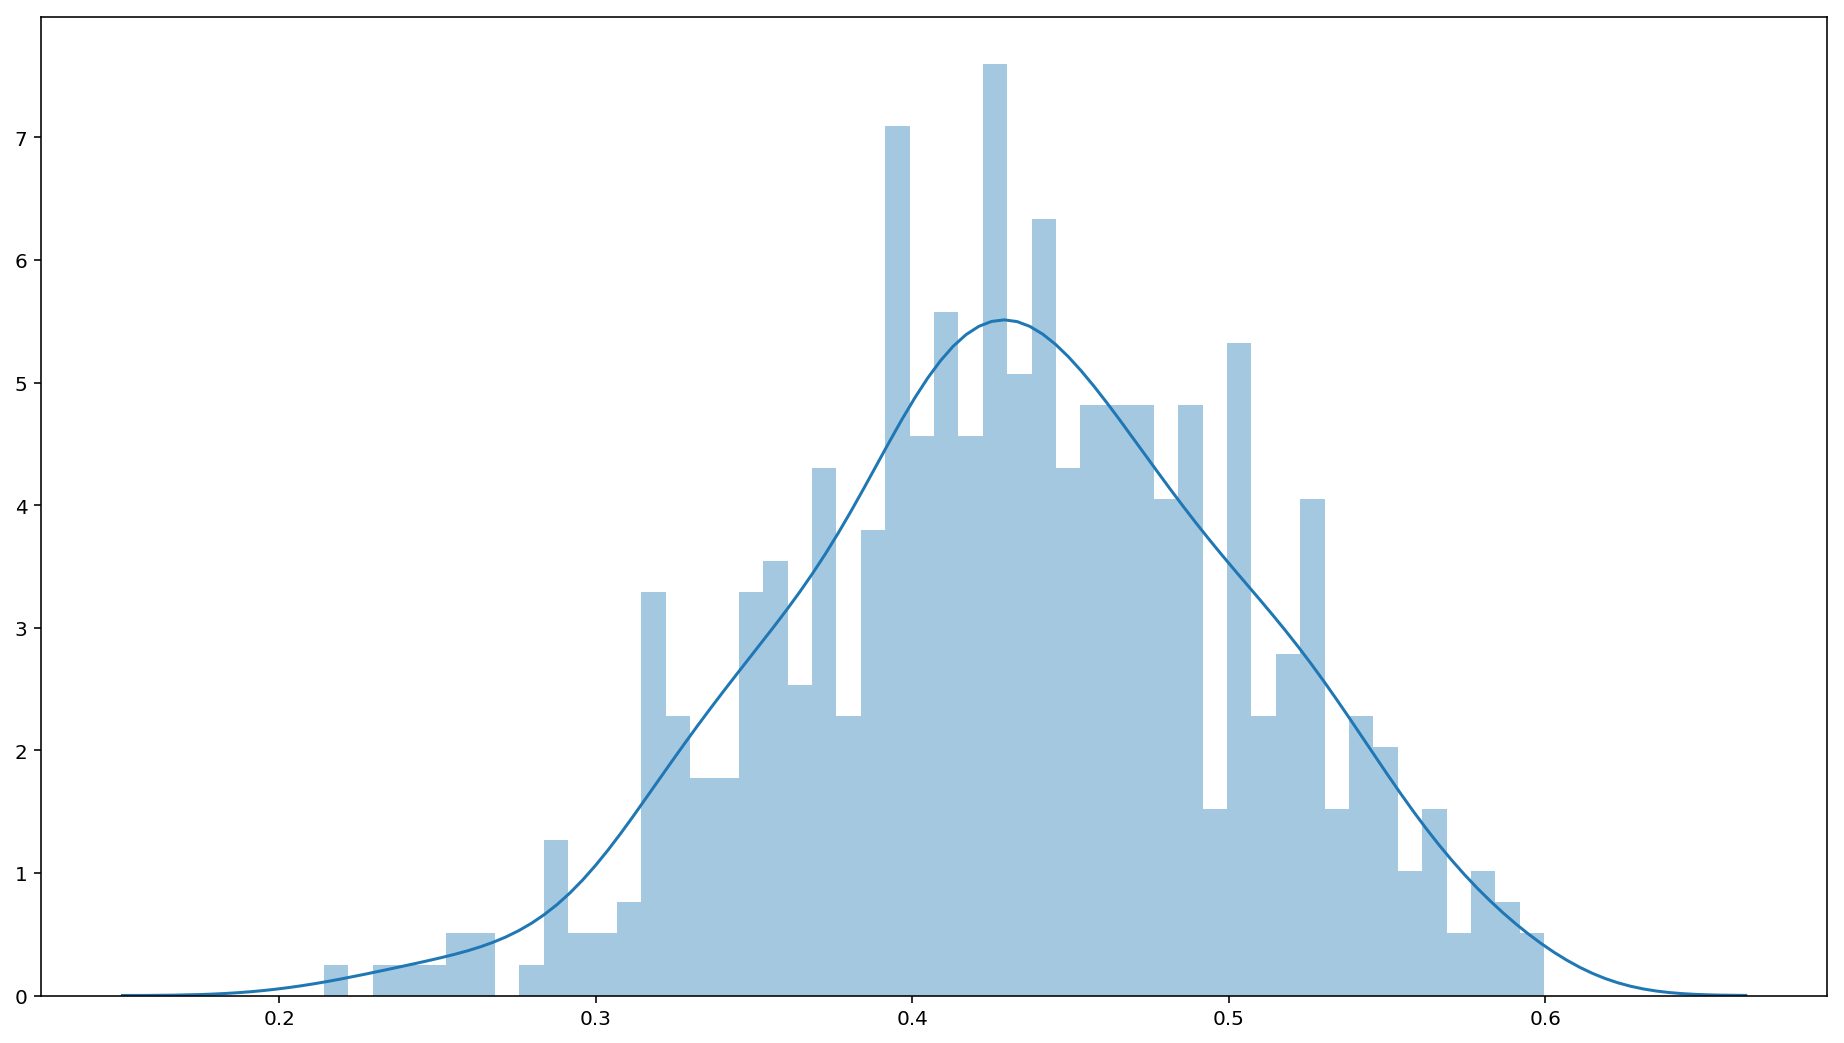

In [12]:
# Histogram wartości aktywacji neuronów
activations = feed_forward(rbm.W, mnist_dataset, sigmoid)
mean_activations = np.mean(activations, 1)
sns.distplot(mean_activations, bins=50)

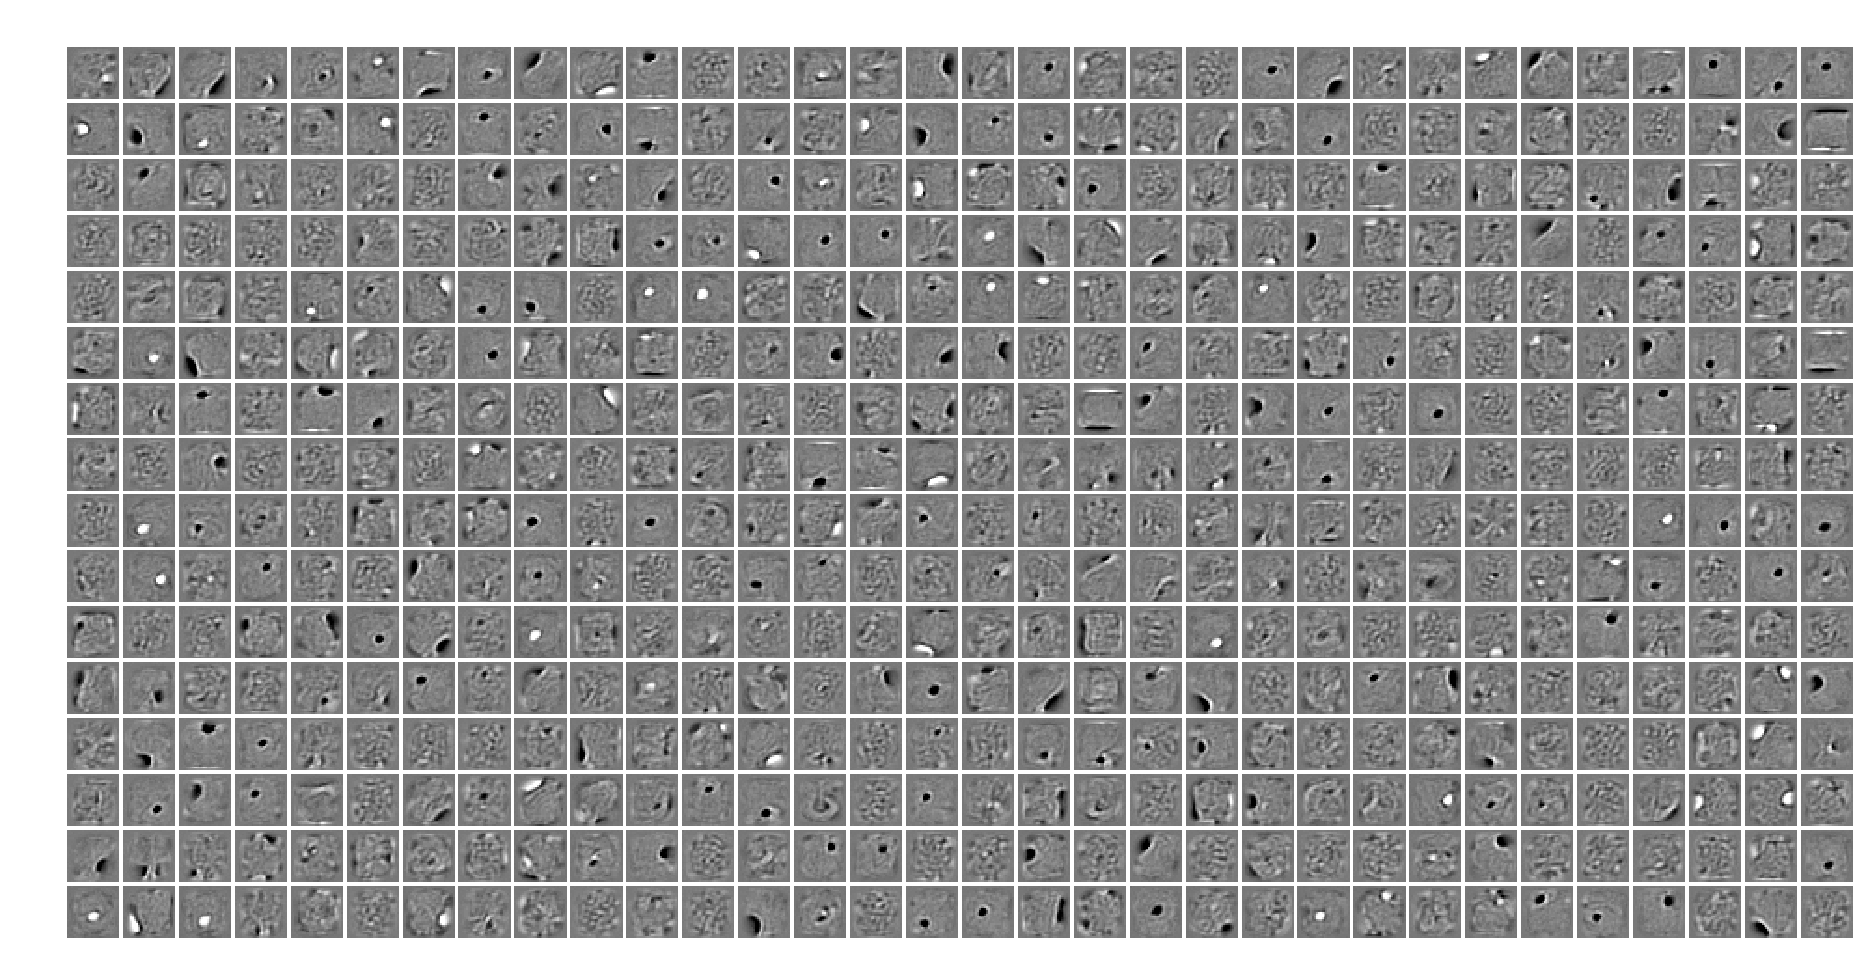

In [13]:
# Filtry w pierwszej warstwie sieci
filters = np.reshape(np.transpose(rbm.W)[:-1, :-1], newshape=(16, -1, 28, 28))
filters = np.clip(filters, -1.0, 1.0)

img = tiles(filters)
plt.matshow(img, cmap='gray', interpolation='none')
plt.axis('off')
plt.show()